In [1]:
import os
import sys
sys.path.append("../cnn")
sys.path.append("../utils")

import torch
from torch.autograd import Variable

from ipywidgets import interact, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# import seaborn as sns; sns.set()

from cnn_md import CNNMultidecoder, CNNVariationalMultidecoder
from hao_data import read_next_utt

In [10]:
# Set up environment variables for the model we want to examine
# NOT necessarily the current environment variables!!

feat_dim=80
left_splice=5
right_splice=5

optimizer="Adam"
learning_rate="0.0001" # Use string instead of float to prevent Python's auto-formatting...
epochs=2
batch_size=256

enc_channels=[256, 256]
enc_kernels=[3, 3]
enc_pools=[3, 3]
enc_fc=[2048]

latent_dim=1024

dec_fc=[2048]
dec_channels=[256, 256]
dec_kernels=[3]
dec_pools=[3]

use_batch_norm=False
use_batch_norm_str = "true" if use_batch_norm else "false"
activation="SELU"
weight_init="xavier_uniform"

enc_channels_delim="_" + "_".join(map(str, enc_channels))
if len(enc_channels) == 0:
     # need to recreate bash join behavior with empty array
    enc_channels_delim="_"
enc_kernels_delim="_" + "_".join(map(str, enc_kernels))
if len(enc_kernels) == 0:
     # need to recreate bash join behavior with empty array
    enc_kernels_delim="_"
enc_pools_delim="_" + "_".join(map(str, enc_pools))
if len(enc_pools) == 0:
     # need to recreate bash join behavior with empty array
    enc_pools_delim="_"
enc_fc_delim="_" + "_".join(map(str, enc_fc))
if len(enc_fc) == 0:
     # need to recreate bash join behavior with empty array
    enc_fc_delim="_"
    
dec_fc_delim="_" + "_".join(map(str, dec_fc))
if len(dec_fc) == 0:
     # need to recreate bash join behavior with empty array
    dec_fc_delim="_"
dec_channels_delim="_" + "_".join(map(str, dec_channels))
if len(dec_channels) == 0:
     # need to recreate bash join behavior with empty array
    dec_channels_delim="_"
dec_kernels_delim="_" + "_".join(map(str, dec_kernels))
if len(dec_kernels) == 0:
     # need to recreate bash join behavior with empty array
    dec_kernels_delim="_"
dec_pools_delim="_" + "_".join(map(str, dec_pools))
if len(dec_pools) == 0:
     # need to recreate bash join behavior with empty array
    dec_pools_delim="_"

debug_model = False
debug_str = "true" if debug_model else "false"
expt_name = "ENC_C%s_K%s_P%s_F%s/LATENT_%d/DEC_F%s_C%s_K%s_P%s/ACT_%s_BN_%s_WEIGHT_INIT_%s/OPT_%s_LR_%s_EPOCHS_%d_BATCH_%d_DEBUG_%s" % (enc_channels_delim,
                                                                                                                                        enc_kernels_delim, 
                                                                                                                                        enc_pools_delim, 
                                                                                                                                        enc_fc_delim,
                                                                                                                                        latent_dim,
                                                                                                                                        dec_fc_delim,
                                                                                                                                        dec_channels_delim,
                                                                                                                                        dec_kernels_delim,                                                                                                                   dec_pools_delim,
                                                                                                                                        activation,
                                                                                                                                        use_batch_norm_str,
                                                                                                                                        weight_init,
                                                                                                                                        optimizer,
                                                                                                                                        learning_rate,
                                                                                                                                        epochs,
                                                                                                                                        batch_size,
                                                                                                                                        debug_str)

time_dim = (left_splice + right_splice + 1)
freq_dim = feat_dim

print("Using experiment %s" % expt_name)

noise_ratio=0.25
print("Noise ratio %s" % str(noise_ratio))

Using experiment ENC_C_256_K_9_P_3_F_2048/LATENT_1024/DEC_F_2048_C_256_K_9_P_3/ACT_SELU_BN_false_WEIGHT_INIT_xavier_uniform/OPT_Adam_LR_0.0001_EPOCHS_25_BATCH_256_DEBUG_false
Noise ratio 0.25


In [11]:
# Load checkpoint (potentially trained on GPU) into CPU memory (hence the map_location)
model_type = "ae"
checkpoint_file = "/data/sls/scratch/atitus5/meng/models/cnn/%s/best_cnn_%s_ratio%s_md.pth.tar" % (expt_name,
                                                                                                   model_type,
                                                                                                   str(noise_ratio))
checkpoint = torch.load(checkpoint_file, map_location=lambda storage,loc: storage)
print("Loaded checkpoint")

Loaded checkpoint


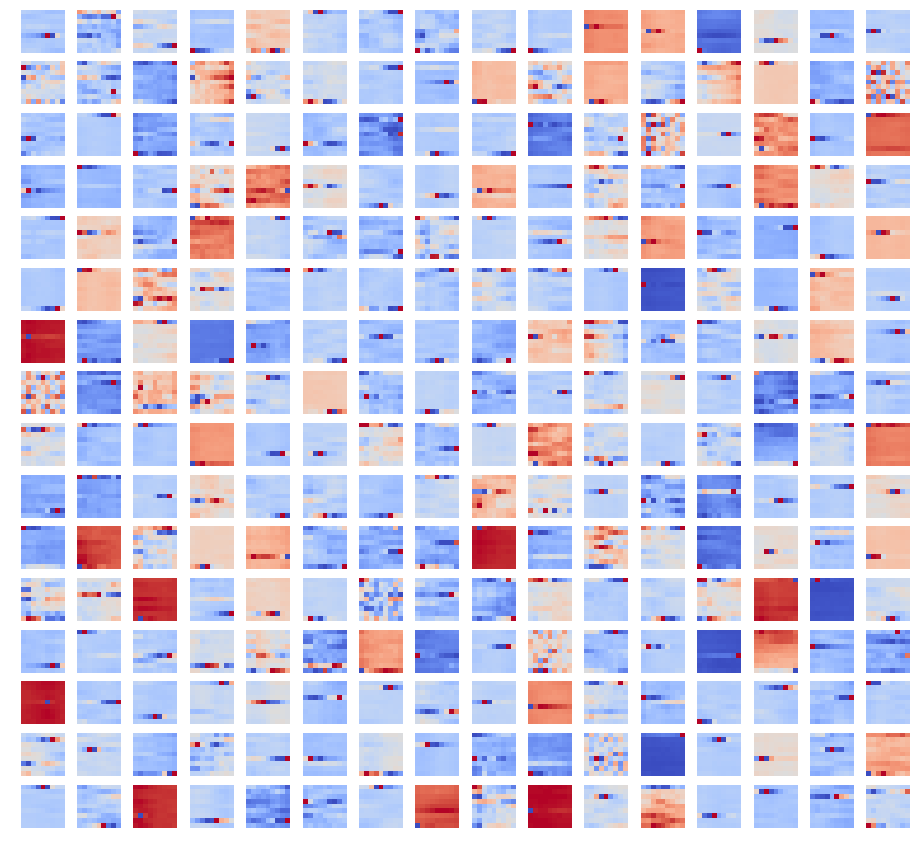

In [12]:
color_map = "coolwarm"
def plotFirstLayerKernels(name, num_cols):
    weights = checkpoint["state_dict"][name].numpy()
    if len(weights.shape) != 4:
        print("plotFirstLayerKernels expects a 4D tensor; got a %dD tensor instead" % len(weights.shape))
    if weights.shape[1] != 1:
        print("plotFirstLayerKernels can only visualize 1 input channel of data")
    num_kernels = weights.shape[0]
        
    num_rows = int(num_kernels // num_cols) + 1
    kernels = weights.reshape((num_kernels, weights.shape[2], weights.shape[3]))
    
    fig = plt.figure(figsize=(16, 16)) 
    for row in range(num_rows):
        for col in range(num_cols):
            kernel_idx = (row * num_cols) + col
            if kernel_idx < num_kernels:
                ax = plt.subplot(num_rows, num_cols, kernel_idx + 1)
                ax.axis('off')   # Pretty-up the result a bit
                plt.imshow(kernels[kernel_idx], cmap=color_map, aspect='equal')
    plt.show()
    
col_count = 16
plotFirstLayerKernels("encoder_conv.conv2d_0.weight", col_count)

In [9]:
# Visualize layers via mean-image method (images/feature matrices for which activation is highest for a unit)
top_count = 100
activations_dir = "/data/sls/scratch/atitus5/meng/activations/cnn/top_%d/%s/%s_ratio%s" % (top_count,
                                                                                           expt_name,
                                                                                           model_type,
                                                                                           str(noise_ratio))

layer_idx = 1
decoder_class = "sdm1"
scp_filename = "%s/activations_holdout-%s-%s_%d.scp" % (activations_dir,
                                                        decoder_class,
                                                        activation,
                                                        layer_idx)
    
all_feats = []
with open(scp_filename, 'r') as scp_file:
    for scp_line in scp_file:
        avg_feats = read_next_utt(scp_line)[1]
        all_feats.append(avg_feats)
num_units = len(all_feats)

# Transpose time and frequency to undo the transpose by imshow
top_images = np.asarray(all_feats).reshape((num_units, freq_dim, time_dim))

def plotFeats(unit_idx):
    plt.imshow(top_images[unit_idx], cmap=color_map, aspect='equal')
    fig = plt.gcf()
    width = 4.0
    height = freq_dim / time_dim * width
    fig.set_size_inches(width, height)
    plt.show()
    
interact(plotFeats, unit_idx=(0, enc_channels[layer_idx]))

<function __main__.plotFeats>